# FFT with our own C++ code and SWIG


We can take this opportunity to show you how to use your own C++ implementation of codes from within python. 

One caveat: we are using `vector<complex<double>>` for our C++ FFT implementation. However, the SWIG numpy setup does not natively support this type, so it's a bit beyond what I would like to show you. 

We will therefore just have to copy our back and forth (once) to use our software. 



## Step 1 : Look at C++ files

First we have our FFT C++ files: 


In [1]:
! cat our_fft.cpp our_fft.hpp


























































#ifndef OUR_FFT_HPP
#define OUR_FFT_HPP
#include <complex>
#include <vector>


// Return Fast Fourier Transform (FFT) using Danielson-Lanczos Lemma
std::vector< std::complex<double> > our_fft(const std::vector< std::complex<double> >& data);
// Return discrete Fourier Transform (DFT)
std::vector< std::complex<double> > our_dft(const std::vector< std::complex<double> >& data);

#endif




## Step 2 : Look at SWIG interface file

The magic of SWIG is to create wrapper C++ functions that use the "cython" interface. We also have an "interface" file for SWIG :

In [2]:
! cat our_fft.i

%module our_fft
/* First: Include your own code.*/
%{
#define OUR_FFT
#include "our_fft.hpp"
%}
/* Next: declare the functions you want to use.*/
std::vector< std::complex<double> > our_fft(const std::vector< std::complex<double> >& data);
std::vector< std::complex<double> > our_dft(const std::vector< std::complex<double> >& data);

/* Finally: include any other libraries and types you need. 
Yes, you need one type per class, so that means one type per
template instance.*/


%include "std_vector.i"
%include "std_complex.i"

namespace std {
  %template(vector_complex_double) vector<std::complex<double> >;
};




## Step 3 : Look at SWIG setup file

This tells SWIG to generate a file called ```our_fft_wrap.cxx``` using source from ```our_fft.cpp``` with C++11. 


In [3]:
! cat setup_our_fft.py

#!/usr/bin/env python

"""
setup.py file for SWIG example
"""

from distutils.core import setup, Extension


our_fft = Extension('_our_fft',
                           sources=['our_fft_wrap.cxx', 'our_fft.cpp'],
                           extra_compile_args=["-std=c++11"],
                           )

setup (name = 'our_fft',
       version = '0.1',
       author      = "Salvatore Rappoccio",
       description = """FFT implemented in C++ to be used in python""",
       ext_modules = [our_fft],
       py_modules = ["our_fft"],
       )


Now create the interface using the interface file. This will create two files, ```example_wrap.cxx``` and ```example.py```. They are not intended to be human-readable, so we don't need to look into them. 

## Step 4: Create SWIG interface from file

In [4]:
! swig -c++ -python our_fft.i 

## Step 5 : compile C++ and interface

This will compile our file ```our_fft.cpp``` along with ```our_fft_wrap.cxx``` using the rules we set (for instance, using the C++11 compiler). 

We are now free to use this in python!

In [5]:
! python setup_our_fft.py build_ext --inplace

/Users/rappoccio/dockers/CompPhys/DataAnalysis/FFT/setup_our_fft.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.core import setup, Extension
running build_ext
building '_our_fft' extension
creating build
creating build/temp.linux-x86_64-3.10
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.10 -c our_fft.cpp -o build/temp.linux-x86_64-3.10/our_fft.o -std=c++11
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include


## Step 6: Make profit: 

First we import the path correctly. 

In [6]:
import sys
import os

sys.path.append( os.path.abspath(".") )

print (sys.path)




['/Users/rappoccio/dockers/CompPhys/DataAnalysis/FFT', '/app/compphys_python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/Users/rappoccio/dockers/CompPhys/DataAnalysis/FFT']


Next we import our actual function from the automatically generated "our_fft.py"

In [7]:
from our_fft import *


And finally, we can use our C++ code from within python!: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt

N = 1024 # number of samples
k = 10.0 # frequency / N
x = np.arange(N) 
# First we use numpy to make a sine wave
y = np.sin( -2. * np.pi * k /N * x ) 

# Now we have to copy the numpy array to a vector<complex<double>>. 
# This is suboptimal, but this type is not automatically supported
# by the swig numpy interface. We're just using this
# for demonstration anyway, though. 
y_ours = vector_complex_double( N )
for i in range(N):
    y_ours[i] = y[i]

Y_ours = our_fft(y_ours)  # Our C++ FFT implementation ... NOW WITH SWIG!

# And convert back to numpy
Y = np.zeros(N, dtype=complex)
for i in range(N):
    Y[i] = Y_ours[i]

Y_abs = abs(Y)
Ynp_abs = abs(Y)


# Success!

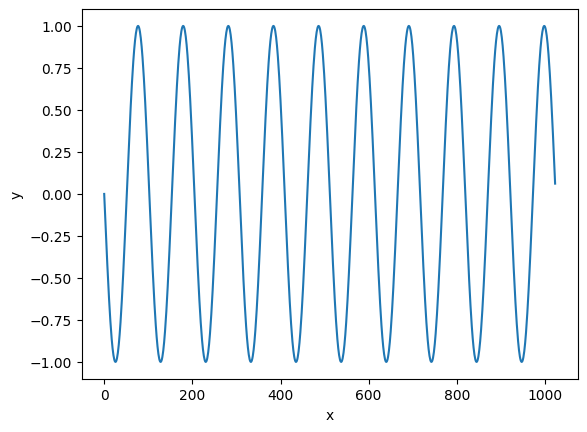

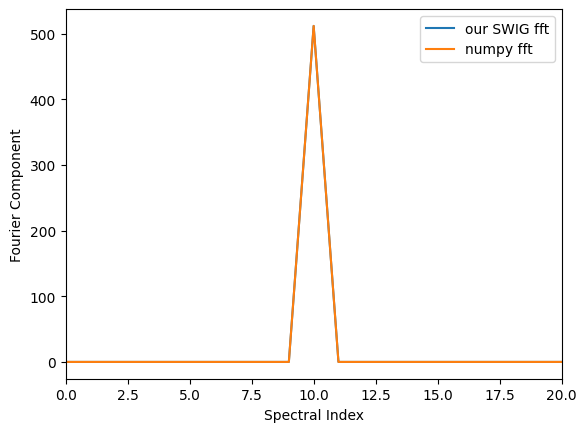

In [9]:

f1 = plt.figure(1)
plt.plot( x, y )
plt.xlabel('x')
plt.ylabel('y')

f2 = plt.figure(2)
plt.plot( x, Y_abs, label="our SWIG fft" )
plt.plot( x, Ynp_abs, label="numpy fft")
plt.ylabel('Fourier Component')
plt.xlabel('Spectral Index')
plt.legend()
plt.xlim([0,20])

plt.show()